<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


# Part 2. Import Packages 
For installation, see `README.MD`

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import datetime
import importlib

from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor import fixed_yahoodownloader # comment this if you chose other path above
importlib.reload(fixed_yahoodownloader) # comment this if you chose other path above
from finrl.meta.preprocessor.fixed_yahoodownloader import YahooDownloader #comment this if you chose the other path above

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLEnsembleAgent
from finrl.agents.stablebaselines3.single_models import DRLSingleAgent
from finrl.agents.stablebaselines3.pets_model import PETSAgent
from finrl.agents.stablebaselines3.mbrl_model import MBRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

/home/hice1/ylin727/.conda/envs/finrl/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [19]:
TRAIN_START_DATE = '2021-01-01'
TRAIN_END_DATE = '2023-01-01'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-01-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (22590, 8)
Display DataFrame:           date       close        high         low        open   volume  tic  \
0  2021-01-04  112.164009  121.800003  116.849998  121.300003  3472100  AXP   
1  2021-01-05  112.762672  119.279999  117.099998  118.260002  2112700  AXP   
2  2021-01-06  116.934135  124.730003  120.809998  121.000000  5861500  AXP   
3  2021-01-07  116.009186  125.690002  117.349998  124.099998  8696600  AXP   
4  2021-01-08  116.123589  122.199997  119.519997  122.070000  2934500  AXP   

   day  
0    0  
1    1  
2    2  
3    3  
4    4  


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [20]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [21]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [22]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 181


In [23]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

* The paper trains and validates 3 model-free agents (A2C, PPO, DDPG) using Rolling-Window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

* We train and validate 2 model-based agents (Random Shooting and PETS) using the sam Rolling-Window method without Ensembling.

##Part 6.1 Ensemble Method

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [25]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {"batch_size": 64,"buffer_size": 100000,"learning_rate": 0.0001,"learning_starts": 100,"ent_coef": "auto_0.1",}
TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}
 
timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 }

In [26]:
ensemble_df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  139.6325983712063
======Model training from:  2021-01-01 to  2023-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1


/home/hice1/ylin727/.conda/envs/finrl/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


--------------------------------------
| time/                 |            |
|    fps                | 37         |
|    iterations         | 100        |
|    time_elapsed       | 13         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | -0.138     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -19.7      |
|    reward             | -1.3214741 |
|    std                | 0.999      |
|    value_loss         | 2.64       |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 66          |
|    iterations         | 200         |
|    time_elapsed       | 15          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -42.6       |
|    explained_variance | 0.117       |
|    learning_ra

KeyError: 'td3'

In [ ]:
ensemble_df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe


## Part 6.2 A2C


In [15]:
a2c_agent = DRLSingleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 model_name='A2C',
                 **env_kwargs)

In [16]:
a2c_df_summary = a2c_agent.run_single_model_strategy(A2C_model_kwargs, 10000)

============Start A2C Strategy============
turbulence_threshold:  201.7186492430374
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/A2C/A2C_126_1
---------------------------------------
| time/                 |             |
|    fps                | 72          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41         |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -108        |
|    reward             | -0.27135813 |
|    std                | 0.996       |
|    value_loss         | 7.05        |
---------------------------------------
-------------------------------------
| time/                 |           |
|

In [17]:
a2c_df_summary

,Iter,Val Start,Val End,A2C Sharpe
0,126,2021-10-04,2022-01-03,0.319733


## Part 6.3 PPO Only

In [18]:
ppo_agent = DRLSingleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 model_name='PPO',
                 **env_kwargs)

In [19]:
ppo_df_summary = ppo_agent.run_single_model_strategy(PPO_model_kwargs, 10000)
ppo_df_summary

============Start PPO Strategy============
turbulence_threshold:  201.7186492430374
======Model training from:  2010-01-01 to  2021-10-04
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/PPO/PPO_126_1
----------------------------------
| time/              |           |
|    fps             | 90        |
|    iterations      | 1         |
|    time_elapsed    | 22        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.1536454 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 2           |
|    time_elapsed         | 47          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012947552 |
|    clip_fraction        | 0.167       |
| 

,Iter,Val Start,Val End,PPO Sharpe
0,126,2021-10-04,2022-01-03,0.092548


## Part 6.4 DDPG Only

In [ ]:
ddpg_agent = DRLSingleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 model_name='DDPG',
                 **env_kwargs)

In [ ]:
ddpg_df_summary = ddpg_agent.run_single_model_strategy(DDPG_model_kwargs, 10000)
ddpg_df_summary

## Part 6.5 MBRL Random Shooting

In [20]:
mbrl_agent = MBRLAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,

                 **env_kwargs)

In [ ]:
mbrl_df_summary = mbrl_agent.run_MBRL_strategy(10000)
mbrl_df_summary

============Start MBRL Strategy============
turbulence_threshold:  201.7186492430374
======Model training from:  2010-01-01 to  2021-10-04
======MBRL Training========
======MBRL Validation from:  2021-10-04 to  2022-01-03
MBRL Sharpe Ratio:  0.3708051993759097
======Trading from:  2022-01-03 to  2022-04-04
turbulence_threshold:  201.7186492430374
======Model training from:  2010-01-01 to  2022-01-03
======MBRL Training========
======MBRL Validation from:  2022-01-03 to  2022-04-04
MBRL Sharpe Ratio:  -0.2375881670032508
======Trading from:  2022-04-04 to  2022-07-06
turbulence_threshold:  201.7186492430374
======Model training from:  2010-01-01 to  2022-04-04
======MBRL Training========


## Part 6.6 PETS

In [ ]:
pets_agent = PETSAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [ ]:
pets_df_summary = pets_agent.run_PETS_strategy(10000)
pets_df_summary

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
models = ['A2C', 'PPO', 'DDPG', 'ensemble', 'MBRL', 'PETS']
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for model in models:
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model,i))
        temp['model'] = model
        df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()

a2c_account_value = df_account_value[df_account_value['model']=='A2C'].join(df_trade_date[validation_window:].reset_index(drop=True))
ppo_account_value = df_account_value[df_account_value['model']=='PPO'].join(df_trade_date[validation_window:].reset_index(drop=True))
ddpg_account_value = df_account_value[df_account_value['model']=='DDPG'].join(df_trade_date[validation_window:].reset_index(drop=True))
ensemble_account_value = df_account_value[df_account_value['model']=='ensemble'].join(df_trade_date[validation_window:].reset_index(drop=True))
mbrl_account_value = df_account_value[df_account_value['model']=='MBRL'].join(df_trade_date[validation_window:].reset_index(drop=True))
pets_account_value = df_account_value[df_account_value['model']=='PETS'].join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.08622266046119016


<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return         -0.088436
Cumulative returns    -0.088101
Annual volatility      0.185081
Sharpe ratio          -0.410029
Calmar ratio          -0.407645
Stability              0.243620
Max drawdown          -0.216945
Omega ratio            0.935511
Sortino ratio         -0.568133
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.966671
Daily value at risk   -0.023619
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = ensemble_df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]

df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])

df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.008656e+06
2    2022-01-05  1.011041e+06
3    2022-01-06  1.002408e+06
4    2022-01-07  9.980177e+05
..          ...           ...
247  2022-12-27  9.147240e+05
248  2022-12-28  9.158399e+05
249  2022-12-29  9.091405e+05
250  2022-12-30  9.118987e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.008656e+06
2022-01-05  1.011041e+06
2022-01-06  1.002408e+06
2022-01-07  9.980177e+05
...                  ...
2022-12-27  9.147240e+05
2022-12-28  9.158399e+05
2022-12-29  9.091405e+05
2022-12-30  9.118987e+05
2023-01-03           NaN

[252 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000754e+06
2022-01-05  9.984221e+05
2022-01-06  9.899922e+05
2022-01-07  9.835481e+05
...                  ...
2022-12-27  9.733564e+05
2022-12-28  9.735313e+05
2022-12-29  9.648311e+05
2022-12-30  9.643457e+05
2023-01-03  9.617932e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.000754e+06  1.008656e+06
2022-01-05  9.984221e+05  1.011041e+06
2022-01-06  9.899922e+05  1.002408e+06
2022-01-07  9.835481e+05  9.980177e+05
...       

<Figure size 1500x500 with 0 Axes>

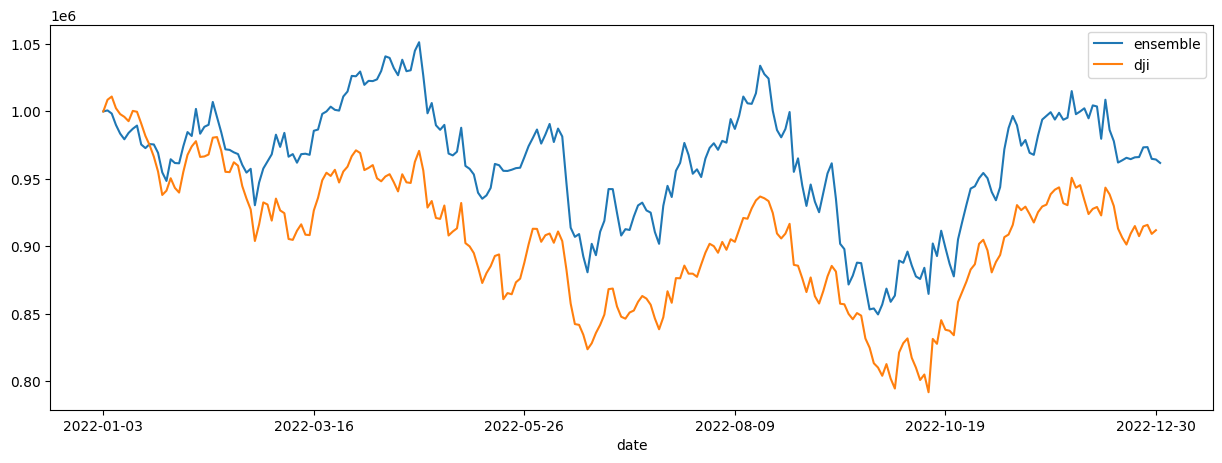

In [ ]:
%matplotlib inline
df.to_csv("df.csv")
df_result_a2c = pd.DataFrame({'date': df_account_value['date'], 'A2C': a2c_account_value['account_value']})
df_result_a2c = df_result_a2c.set_index('date')
df_result_a2c.to_csv("df_result_a2c.csv")

df_result_ppo = pd.DataFrame({'date': df_account_value['date'], 'PPO': ppo_account_value['account_value']})
df_result_ppo = df_result_ppo.set_index('date')
df_result_ppo.to_csv("df_result_ppo.csv")

df_result_ddpg = pd.DataFrame({'date': df_account_value['date'], 'DDPG': ddpg_account_value['account_value']})
df_result_ddpg = df_result_ddpg.set_index('date')
df_result_ddpg.to_csv("df_result_ddpg.csv")

df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')
df_result_ensemble.to_csv("df_result_ensemble.csv")

df_result_mbrl = pd.DataFrame({'date': df_account_value['date'], 'MBRL': mbrl_account_value['account_value']})
df_result_mbrl = df_result_mbrl.set_index('date')
df_result_mbrl.to_csv("df_result_mbrl.csv")

df_result_pets = pd.DataFrame({'date': df_account_value['date'], 'PETS': pets_account_value['account_value']})
df_result_pets = df_result_pets.set_index('date')
df_result_pets.to_csv("df_result_pets.csv")

result = pd.DataFrame()
result = pd.concat([df_result_a2c, df_result_ppo, df_result_ddpg, df_result_ensemble, df_result_mbrl, df_result_pets, df_dji],axis=1)
result.to_csv("result.csv")
result.columns = ['A2C', 'PPO', 'DDPG', 'Ensemble', 'MBRL', 'PETS', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

import matplotlib.pyplot as plt
import pandas as pd

def plot_strategy_comparison(df_account_value, df_trade_date, baseline_data, strategies, output_csv=True):
    """
    Plots the baseline vs. multiple trading strategies account values.

    Args:
        df_account_value (pd.DataFrame): DataFrame containing account values for different strategies.
        df_trade_date (pd.DataFrame): DataFrame containing trade dates.
        baseline_data (pd.DataFrame): Baseline data (e.g., DJI values).
        strategies (list): List of strategy names to include in the plot.
        output_csv (bool): Whether to save intermediate and result data to CSV.

    Returns:
        None
    """
    # Adjust trade dates
    trade_dates = df_trade_date.iloc[validation_window:].reset_index(drop=True)
    
    result_dfs = {}
    for strategy in strategies:
        strategy_account_value = (
            df_account_value[df_account_value['model'] == strategy]
            .join(trade_dates)
            .reset_index(drop=True)
        )
        result_dfs[strategy] = pd.DataFrame({
            'date': strategy_account_value['date'],
            strategy: strategy_account_value['account_value']
        }).set_index('date')

        if output_csv:
            result_dfs[strategy].to_csv(f"df_result_{strategy.lower()}.csv")

    # Add baseline to result
    baseline_data['dji'] = baseline_data['close'] / baseline_data['close'].iloc[0] * env_kwargs["initial_amount"]
    baseline_data = baseline_data.set_index(baseline_data.columns[0])
    if output_csv:
        baseline_data.to_csv("df_dji.csv")

    result = pd.concat([df.set_index(df.columns[0]) for df in result_dfs.values()] + [baseline_data['dji']], axis=1)
    result.columns = strategies + ['dji']
    if output_csv:
        result.to_csv("result.csv")

    # Plotting
    plt.figure(figsize=(15, 5))
    result.plot()
    plt.title("Baseline vs Strategies")
    plt.xlabel("Date")
    plt.ylabel("Account Value")
    plt.legend(loc='upper left')
    plt.show()

# Usage example
models = ['A2C', 'PPO', 'DDPG', 'ensemble', 'MBRL', 'PETS']
plot_strategy_comparison(
    df_account_value,
    df_trade_date,
    df_dji_,
    models,
    output_csv=True
)
